In [235]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text

NERF_SYNTHETIC_SCENES = [
    "chair",
    "drums",
    "ficus",
    "hotdog",
    "lego",
    "materials",
    "mic",
    "ship",
]
MIPNERF360_UNBOUNDED_SCENES = [
    "garden",
    "bicycle",
    "bonsai",
    "counter",
    "kitchen",
    "room",
    "stump",
]
methods = ["Occupancy Grid", "Proposal Network", "Proposal Grid"]
cdict = {
    "Occupancy Grid": "red",
    "Proposal Network": "blue",
    "Proposal Grid": "green",
}
data_dir = {
    "Occupancy Grid": "occ_grid_v2",
    "Proposal Network": "prop_net",
    "Proposal Grid": "prop_grid",
}

In [238]:
def load_data(
    method,
    dataset,
    xlabel="train_time_total",
    ylabel="test_psnr_avg",
    seeds_to_delete=[],
):
    if dataset == "synthetic":
        scenes = NERF_SYNTHETIC_SCENES
    elif dataset == "unbounded":
        scenes = MIPNERF360_UNBOUNDED_SCENES
    else:
        raise ValueError("Unknown dataset")

    seeds = os.listdir(
        os.path.join(
            "/home/ruilongli/workspace/nerfacc/outputs",
            data_dir[method],
            scenes[0],
        )
    )
    seeds = [int(seed.split(".")[0]) for seed in seeds]

    Xs, Ys, seeds_used = [], [], []
    for seed in seeds:
        paths = [
            os.path.join(
                "/home/ruilongli/workspace/nerfacc/outputs",
                data_dir[method],
                scene,
                f"{seed:05d}.json",
            )
            for scene in scenes
        ]
        if any([not os.path.exists(path) for path in paths]):
            continue

        y_mean = []
        x_mean = []
        for path in paths:
            with open(path) as f:
                data = json.load(f)
                y_mean.append(data[ylabel])
                x_mean.append(data[xlabel])
        y_mean = sum(y_mean) / len(y_mean)
        x_mean = sum(x_mean) / len(x_mean)
        Xs.append(x_mean)
        Ys.append(y_mean)
        seeds_used.append(seed)

    new_Xs, new_Ys, new_seeds_used = [], [], []
    for X, Y, seed in zip(Xs, Ys, seeds_used):
        if seed not in seeds_to_delete:
            new_Xs.append(X)
            new_Ys.append(Y)
            new_seeds_used.append(seed)
    Xs = new_Xs
    Ys = new_Ys
    seeds_used = new_seeds_used

    Xs = np.array(Xs)
    Ys = np.array(Ys)
    seeds_used = np.array(seeds_used)
    mask = ~np.isnan(Ys)

    Xs = Xs[mask]
    Ys = Ys[mask]
    seeds_used = seeds_used[mask]

    return Xs, Ys, seeds_used

synthetic
Occupancy Grid [25627  8468 22237 26633]
Proposal Network [24489 31978 31236 17156 19263 19076]
Proposal Grid [ 7196 29989 26299]
Occupancy Grid [26633 22237  8468 25627]
Proposal Network [19076 19263 17156 31236 31978 24489]
Proposal Grid [26299 29989  7196]
unbounded
Occupancy Grid [20930  2827  9562  7367 29310]
Proposal Network [12530 12070  6432 18247 28320 10089]
Proposal Grid [ 5935  6127 23441  9105]
Occupancy Grid [ 7367 29310  9562  2827 20930]
Proposal Network [10089 28320 18247  6432 12070 12530]
Proposal Grid [ 9105 23441  6127  5935]


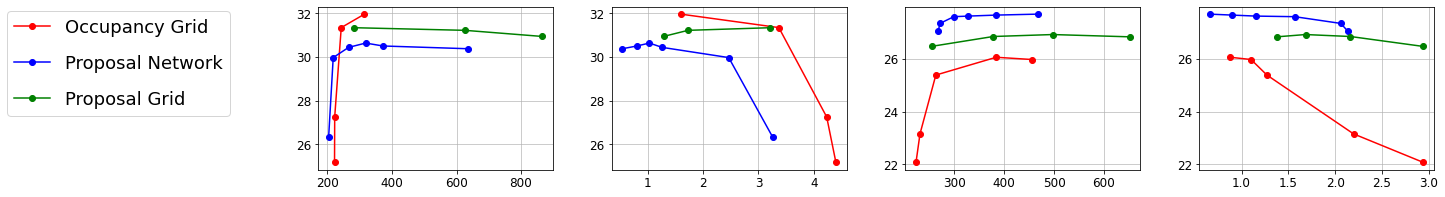

In [239]:
SEEDS_TO_DELETE = {
    ("synthetic", "Occupancy Grid"): [
        26957,
        30863,
        18133,
        26533,
        25794,
        29365,
        1460,
        10645,
    ],
    ("synthetic", "Proposal Grid"): [
        25316,
        3179,
        18627,
        16226,
        30868,
        10581,
        21491,
        17173,
    ],
    ("synthetic", "Proposal Network"): [
        13553,
        14594,
        9822,
        7440,
        15172,
        1275,
    ],
    ("unbounded", "Occupancy Grid"): [
        11907,
        17672,
        32420,
        7326,
        25602,
        27198,
        6583,
        8488,
        9609,
        17269,
        3605,
    ],
    ("unbounded", "Proposal Grid"): [
        11862,
        6762,
    ],
    ("unbounded", "Proposal Network"): [
        29908,
        29908,
        15625,
        3980,
        940,
        5588,
        17700,
        6283,
        17773,
        32414,
        29669,
        24194,
        70,
        # 12530,
        15934,
        23941,
    ],
}
r, c = 1, 4
w, h = 5, 3

# title_font_size = 16 * 1.5
legend_font_size = 12 * 1.5
x_tick_font_size = 12
y_tick_font_size = 12
x_label_font_size = 12 * 1.25
y_label_font_size = 12 * 1.25

fig, axes = plt.subplots(
    nrows=r,
    ncols=c,
    figsize=(c * w, r * h),
    gridspec_kw={"width_ratios": [w] * c},
    # constrained_layout=True,
)
for i, dataset in enumerate(["synthetic", "unbounded"]):
    # for dataset in ["synthetic"]:
    # for dataset in ["unbounded"]:
    print(dataset)
    for method in methods:
        # for method in ["Occupancy Grid"]:
        # for method in ["Proposal Grid"]:
        # for method in ["Proposal Network"]:
        seeds_to_delete = SEEDS_TO_DELETE.get((dataset, method), [])
        Xs, Ys, seeds_used = load_data(
            method,
            dataset,
            xlabel="train_time_total",
            ylabel="test_psnr_avg",
            seeds_to_delete=seeds_to_delete,
        )
        inds = np.argsort(Xs)
        Xs = Xs[inds]
        Ys = Ys[inds]
        seeds_used = seeds_used[inds]
        print(method, seeds_used)
        axes[i * 2 + 0].plot(Xs, Ys, "o-", label=method, c=cdict[method])
        # adjust_text(
        #     [plt.text(X, Y, S) for X, Y, S in zip(Xs, Ys, seeds_used)],
        #     only_move={"points": "y", "texts": "y"},
        #     arrowprops=dict(arrowstyle="->", color="r", lw=0.5),
        # )

    # plt.xlabel("Train Time (s)")
    # plt.ylabel("PSNR (dB)")
    # plt.legend()
    # plt.show()
    # axes[i][0].set_xscale("log")
    axes[i * 2 + 0].grid(alpha=0.8)
    axes[i * 2 + 0].set_axisbelow(True)
    # axes[i * 2 + 0].set_ylabel("PSNR", fontsize=y_label_font_size)
    # axes[i * 2 + 0].set_xlabel(
    #     "Training time (s) $\downarrow$", fontsize=x_label_font_size
    # )
    axes[i * 2 + 0].tick_params(axis="x", labelsize=x_tick_font_size)
    axes[i * 2 + 0].tick_params(axis="y", labelsize=y_tick_font_size)

    for method in methods:
        seeds_to_delete = SEEDS_TO_DELETE.get((dataset, method), [])
        Xs, Ys, seeds_used = load_data(
            method,
            dataset,
            xlabel="test_fps",
            ylabel="test_psnr_avg",
            seeds_to_delete=seeds_to_delete,
        )
        inds = np.argsort(Xs)
        Xs = Xs[inds]
        Ys = Ys[inds]
        seeds_used = seeds_used[inds]
        print(method, seeds_used)
        axes[i * 2 + 1].plot(Xs, Ys, "o-", label=method, c=cdict[method])
        # for X, Y, seed in zip(Xs, Ys, seeds_used):
        #     plt.annotate(f"ID:{seed:05d}", (X, Y))
    axes[i * 2 + 1].grid(alpha=0.8)
    axes[i * 2 + 1].set_axisbelow(True)
    # axes[i * 2 + 1].set_ylabel("PSNR", fontsize=y_label_font_size)
    # axes[i * 2 + 1].set_xlabel(
    #     "Rendering FPS $\\uparrow$", fontsize=x_label_font_size
    # )
    axes[i * 2 + 1].tick_params(axis="x", labelsize=x_tick_font_size)
    axes[i * 2 + 1].tick_params(axis="y", labelsize=y_tick_font_size)

    # plt.xlabel("Test FPS (it/s)")
    # plt.ylabel("PSNR (dB)")
    # plt.legend()
    # plt.show()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    # loc="center left",
    bbox_to_anchor=(0, 0, 0.07, 0.9),
    ncol=1,
    fontsize=legend_font_size,
    # frameon=False,
    labelspacing=1,
)
fig.subplots_adjust(wspace=0.25)

In [240]:
fig.savefig("analysis_pretty.pdf", dpi=500, bbox_inches="tight")

In [ ]:
r, c = 2, 2
w, h = 4, 3

title_font_size = 20
legend_font_size = 16
x_tick_font_size = 14
y_tick_font_size = 14

fig, axes = plt.subplots(
    nrows=r,
    ncols=c,
    figsize=(c * w, r * h),
    gridspec_kw={"width_ratios": [w] * c},
    constrained_layout=True,
    # sharex=True,
)
for k, title, ax in zip(
    ["mPSNR", "mSSIM", "mLPIPS", "PCK-T"],
    [
        "mPSNR$\\uparrow$",
        "mSSIM$\\uparrow$",
        "mLPIPS$\\downarrow$",
        "PCK-T$\\uparrow$",
    ],
    axes,
):
    sns.barplot(
        data=data
        if k in ["mPSNR", "mSSIM", "mLPIPS"]
        else data[data["Model"] != "T-NeRF"],
        # data=data,
        x="Model",
        y=k,
        hue="Data",
        palette=sns.color_palette(
            LinearSegmentedColormap.from_list(
                "oggr", ["#FF7437", "#B1D6B6"], 2
            )(np.arange(2))
        ),
        alpha=1,
        ax=ax,
    )
    ax.yaxis.set_major_formatter(
        FormatStrFormatter(
            {
                "mPSNR": "%.2f",
                "mSSIM": "%.3f",
                "mLPIPS": "%.3f",
                "PCK-T": "%.3f",
            }[k]
        )
    )
    ax.set_title(title, fontsize=title_font_size)
    ax.legend(
        loc="upper center" if k == "mPSNR" else "best",
    )
    ax.legend([], [], frameon=False)
    vmax = data[k].max()
    vmin = data[k].min()
    vrange = vmax - vmin
    vmax += vrange * (0.1 if k != "mPSNR" else 0.2)
    vmin -= vrange * 0.1
    ax.set_ylim(
        bottom=vmin,
        top=vmax,
    )
    ax.tick_params(
        axis="x",
        labelsize=x_tick_font_size,
        rotation=-20,
    )
    ax.tick_params(
        axis="y",
        labelsize=y_tick_font_size,
    )
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0, 0, 0, 0.75),
    ncol=1,
    fontsize=legend_font_size,
    labelspacing=1,
)

# plt.tight_layout()